# Test Model with Images

In [10]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torchvision
import cv2
from torchvision import datasets, models, transforms
import models
from PIL import Image
import matplotlib.pyplot as plt
img_size = 224
num_classes = 2

device = torch.device('cuda')
print('Device:', device)
num_gpu = torch.cuda.device_count()
print('Number of available GPUs:', num_gpu)

Device: cuda
Number of available GPUs: 1


#### Load Test Images

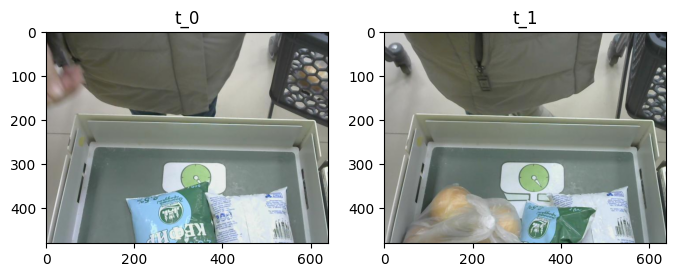

In [11]:
t_0_name = '10322.png'
t_1_name = '10323.png'

ref_img_orig = Image.open('data_renamed/' + t_0_name).convert('RGB')
test_img_orig = Image.open('data_renamed/' + t_1_name).convert('RGB')


ref_img = Image.open('data_renamed/' + t_0_name).convert('RGB')
test_img = Image.open('data_renamed/' + t_1_name).convert('RGB')
#test_img = Image.open('test_img.png')
#ref_img = Image.open('ref_img.png')
fig=plt.figure(figsize=(8, 8))
fig.add_subplot(1, 2, 1)
plt.imshow(ref_img)
plt.title('t_0')
fig.add_subplot(1, 2, 2)
plt.imshow(test_img)
plt.title('t_1')
plt.show()

#### Transforms on Input Image

In [12]:
trf = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        #transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# Apply transform and bring to the format batch, channels, width, height
test_img = trf(test_img).unsqueeze(0)
ref_img = trf(ref_img).unsqueeze(0)
print('test_img.shape:', test_img.shape)

test_img.shape: torch.Size([1, 3, 224, 224])


#### Initialize Model and Load Checkpoint

In [13]:
change_net = models.ChangeNet(num_classes=num_classes)
if num_gpu > 1:
    change_net = nn.DataParallel(change_net)
change_net = change_net.to(device)

checkpoint = torch.load('cur_prod_datasetV3/best_model_clear_new_9_0.551.pkl')
change_net.load_state_dict(checkpoint)
change_net = change_net.eval()

#### Run Model

In [14]:
with torch.no_grad():
    pred = change_net([ref_img.to(device), test_img.to(device)])
# Get the correct class by looking for the max value across channels
    _, output = torch.max(pred, 1)      

#### Display Results

In [15]:
mask = output.squeeze(0).cpu().detach().numpy()

t1 = cv2.imread('data_renamed/' + t_1_name)
t1 = cv2.cvtColor(t1, cv2.COLOR_RGB2BGR)
resized = cv2.resize(t1, (224,224), interpolation = cv2.INTER_AREA)

resized[mask == 0] = 1

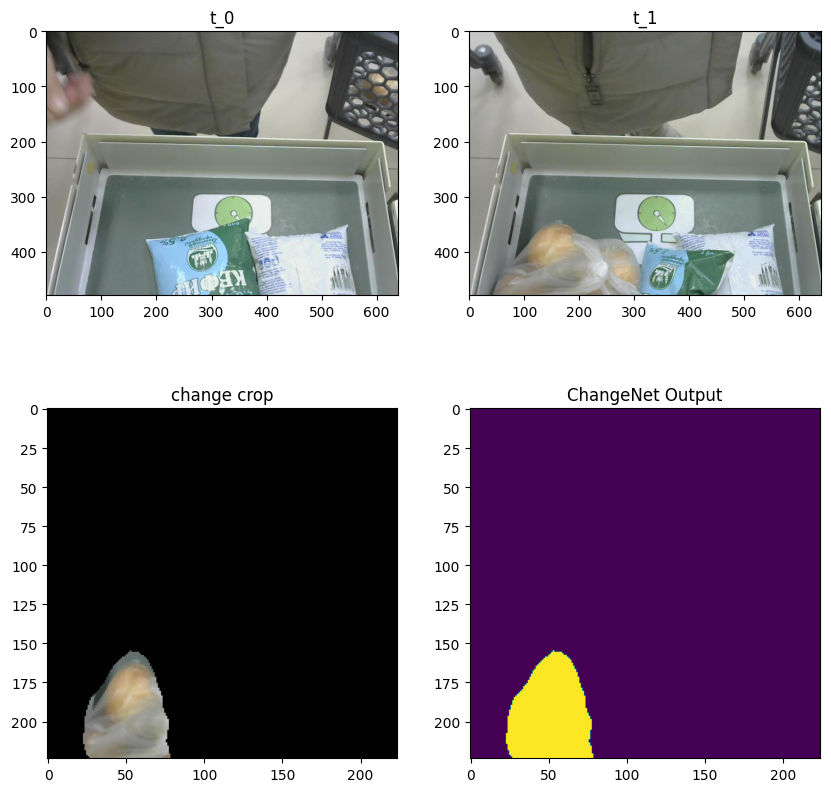

In [16]:
fig=plt.figure(figsize=(10, 10))
fig.add_subplot(2, 2, 1)
plt.imshow(ref_img_orig)
plt.title('t_0')

fig.add_subplot(2, 2, 2)
plt.imshow(test_img_orig)
plt.title('t_1')

fig.add_subplot(2, 2, 3)
plt.imshow(resized)
plt.title('change crop')

fig.add_subplot(2, 2, 4)
plt.imshow(output.squeeze(0).squeeze(0).cpu().numpy())
plt.title('ChangeNet Output')

plt.show()